In [94]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context# this is for me 


In [95]:
import torch
import torchvision 
import torch.nn as nn
from torchvision import transforms , datasets
from torch.utils.data import DataLoader

In [96]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [97]:
from pathlib import Path
train_dataset = torchvision.datasets.CIFAR10(root=Path('./data')
                                           ,train=True,
                                           transform=transform,
                                           download=True)
test_dataset = torchvision.datasets.CIFAR10(root=Path('./data')
                                           ,train=False,
                                           transform=transform,
                                           download=True)

In [98]:
import os
BATCH_SIZE=64
NUM_WORKERS=os.cpu_count()
train_dataloader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS)
class_names = train_dataset.classes

In [99]:
train_dataloader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [102]:
images , _ =next(iter(test_dataloader))

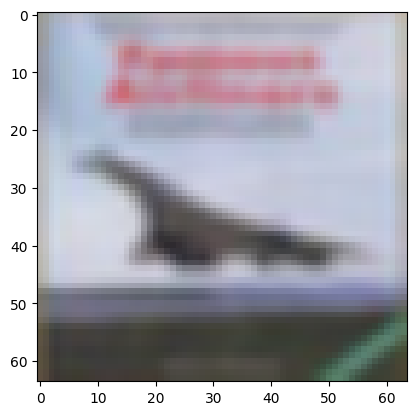

In [103]:
import matplotlib.pyplot as plt 
plt.imshow(images[3].permute(1,2,0))


In [112]:

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder part
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),   # -> [32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # -> [64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # -> [128, 8, 8]
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1) # -> [256, 4, 4]
        )
        
        # Decoder part
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # -> [128, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # -> [64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),   # -> [32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1), 
            nn.Sigmoid()  # Keep pixel values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)   # Encode image to latent space
        #print(x.shape)
        x = self.decoder(x)   # Decode to reconstruct original image
        return x

In [113]:
model = ConvAutoencoder()

In [114]:
model(images[0]).shape

torch.Size([3, 64, 64])

In [115]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lr = 0.001, params = model.parameters())

In [116]:
epochs = 5
from tqdm.auto import tqdm
for epoch in tqdm(range(epochs)):
    for batch , (X,y) in enumerate(train_dataloader):
        pred = model(X)
        loss = loss_fn(pred ,X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"{epoch}_epoch {loss:0.4}_loss")    
    

  0%|          | 0/5 [00:00<?, ?it/s]

0_epoch 0.002602_loss
1_epoch 0.001288_loss
2_epoch 0.0009568_loss
3_epoch 0.0006818_loss
4_epoch 0.0004503_loss


In [125]:
pred_img = model(images[0])
pred_img.shape

torch.Size([3, 64, 64])

In [122]:
images[0].permute(1,2,0).shape


torch.Size([64, 64, 3])

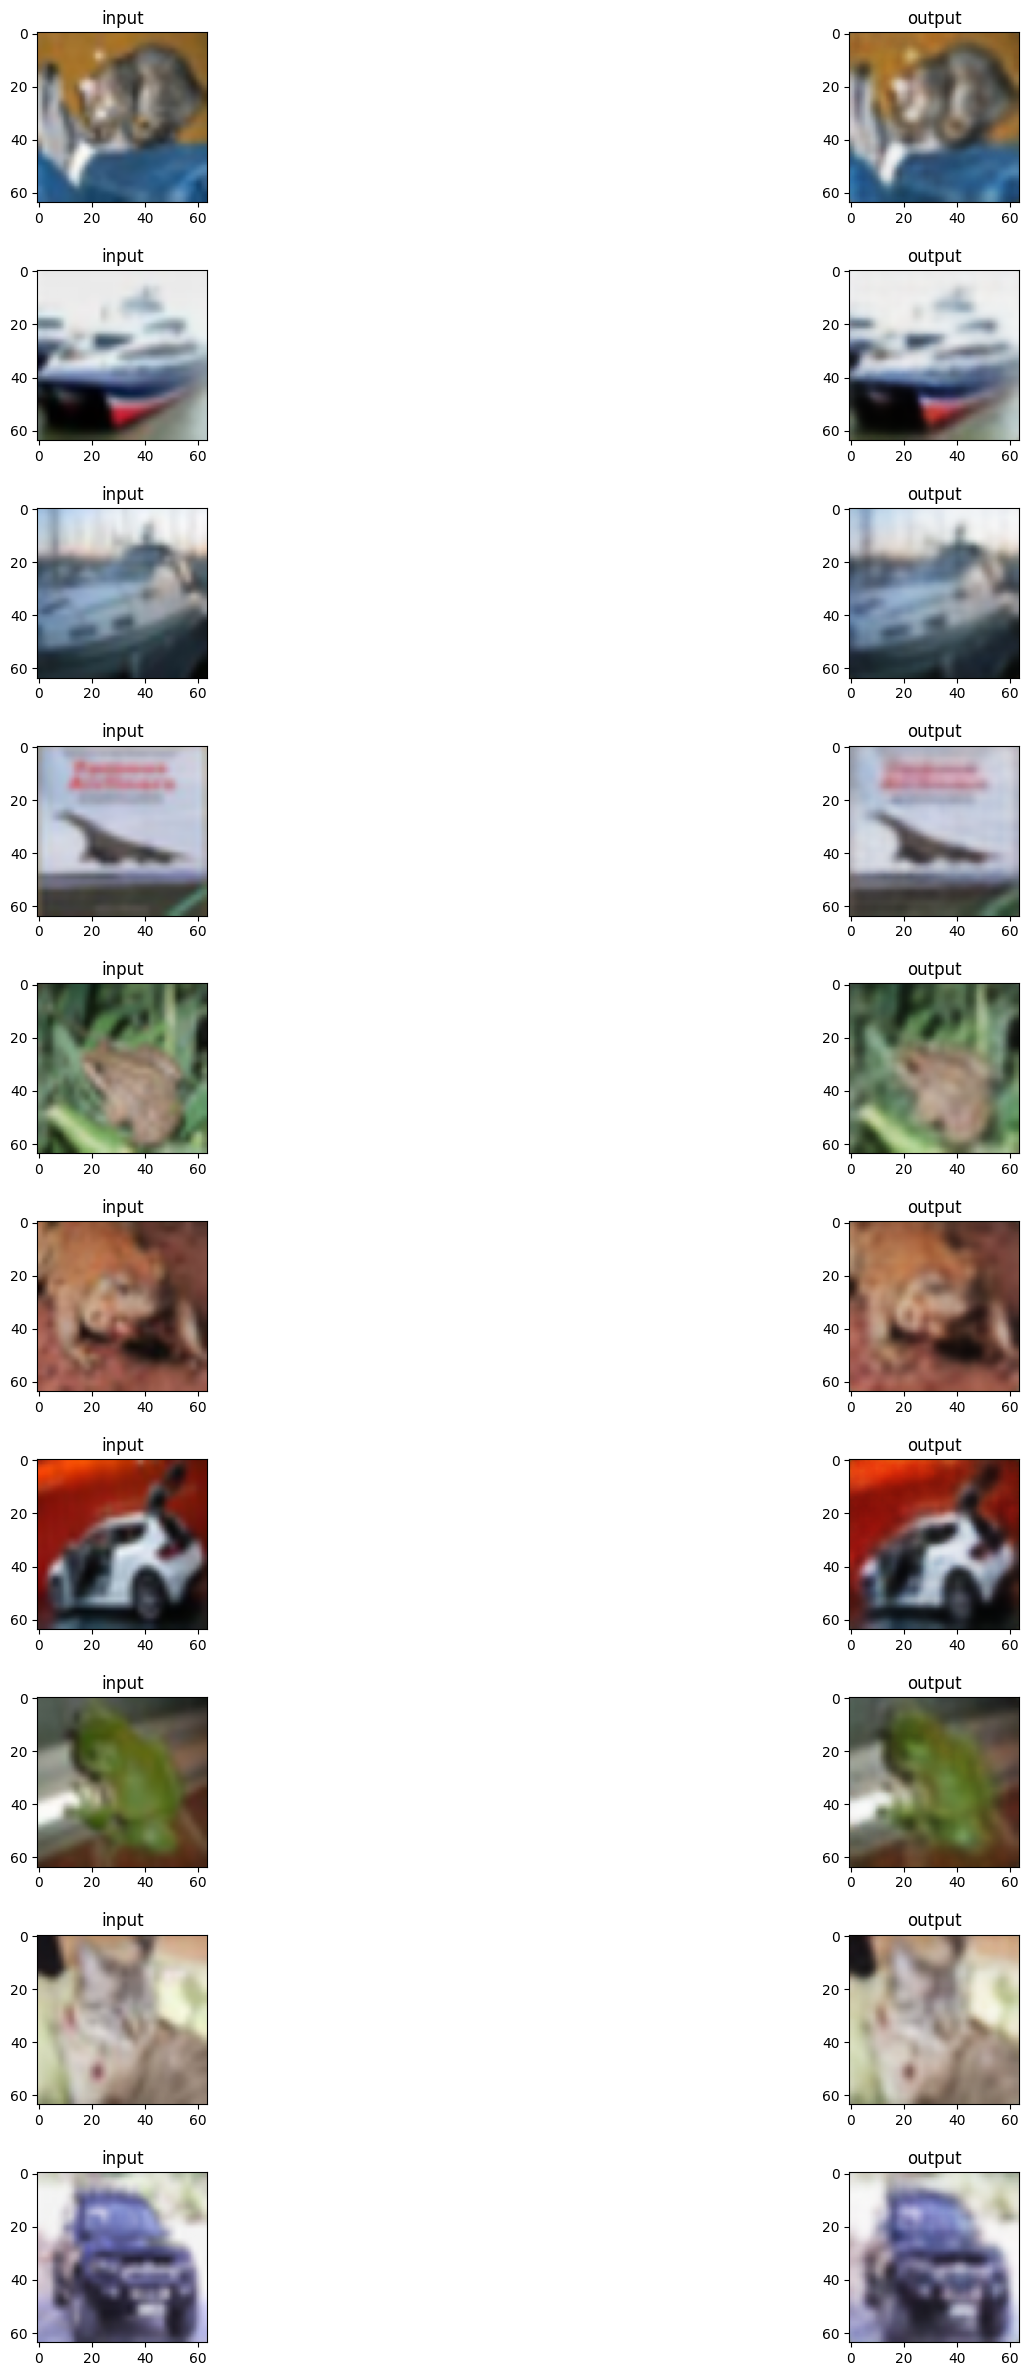

In [144]:
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(20, 30))
fig.subplots_adjust(hspace=0.4, wspace=.1)
for i in range(10):
    axes[i,0].imshow(images[i].permute(1,2,0))
    axes[i,0].set_title('input')
   
    with torch.no_grad():
        pred_img = model(images[i])
    axes[i,1].imshow(pred_img.squeeze(dim=1).permute(1,2,0))
    axes[i,1].set_title('output')

In [143]:
# ok let's use that to encoder on our dataset  
x = images[0]     # shape -> (1, 32, 32)
print(class_names[_[0]])
encoded = model.encoder(images[0])
encoded.element_size() *encoded.nelement()

cat


16384

In [140]:
decoded = model.decoder(encoded)
decoded.element_size() *decoded.nelement()

49152

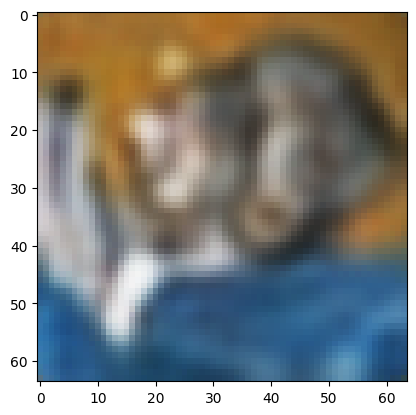

In [141]:
plt.imshow(decoded.detach().permute(1,2,0))